# Dataset preparation from HF

> Data will be downloaded from hugging face and then will be processed to get the data in the format we want.

In [1]:
#| default_exp hf_data_prep

In [64]:
#| export
from typing import List, Dict, Union, Optional
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import albumentations as A
from tqdm.auto import tqdm
from statistics import mean
from fastcore.test import *
mpl.rcParams['image.cmap'] = 'gray' 

In [51]:
#| export
import torch
from torch.utils.data import Dataset as TorchDataset
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import monai

In [45]:
#| export
from datasets import load_dataset, Dataset
from transformers import SamProcessor
from transformers import SamModel
processor = SamProcessor.from_pretrained('facebook/sam-vit-base')

In [19]:
#| hide
train_dataset = load_dataset(
    "hasangoni/Electron_microscopy_dataset",
    split="train")
val_dataset = load_dataset(
    "hasangoni/Electron_microscopy_dataset",
    split="test")

Found cached dataset parquet (/home/hasan/.cache/huggingface/datasets/hasangoni___parquet/hasangoni--Electron_microscopy_dataset-2e0b773ba35eb66f/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Found cached dataset parquet (/home/hasan/.cache/huggingface/datasets/hasangoni___parquet/hasangoni--Electron_microscopy_dataset-2e0b773ba35eb66f/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [7]:
#| hide
im_path = Path(Path.cwd().parent/'data/patch_images')
msk_path = Path(Path.cwd().parent/'data/patch_masks')
im_path_tst = Path(Path.cwd().parent/'data/test_patch_images')
msk_path_tst = Path(Path.cwd().parent/'data/test_patch_masks')

In [20]:
bbox_test = train_dataset['label'][3]

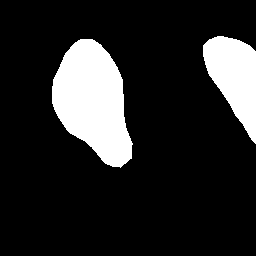

In [21]:
bbox_test

In [22]:
#| export
def get_bounding_box(
        ground_truth_map:np.ndarray, # mask image type cv2
        ):
    "Get bounding box coordinates from mask image"


    y_, x_ = np.where(ground_truth_map> 0)
    x_min, x_max = np.min(x_), np.max(x_)
    y_min, y_max = np.min(y_), np.max(y_)

    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]

    return bbox

tesing get_bounding_box

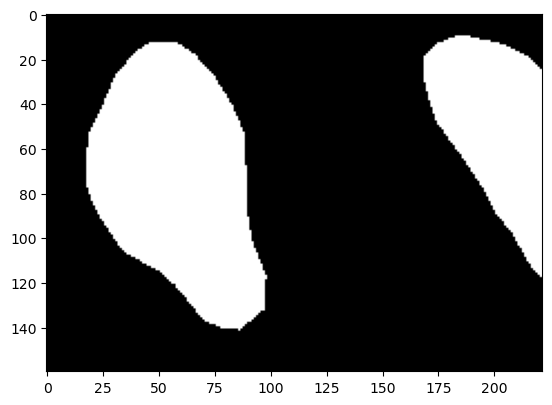

In [23]:
bbox = get_bounding_box(np.array(bbox_test))
plt.imshow(np.array(bbox_test)[bbox[1]:bbox[3],bbox[0]:bbox[2]]);

In [31]:
#| export
class SAMDataset(TorchDataset):
    "Creating dataset for SAM Training"

    def __init__(
            self,
            dataset, # pytorch dataset
            processors # hf model processor
            ):
        self.dataset = dataset
        self.processors = processors

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        mask = np.array(item['label'])
        prompt = get_bounding_box(mask) # bounding box around mask

        # prepare image and prompt for model
        inputs = self.processors(
                                 image, 
                                 input_boxes=[[prompt]],
                                 return_tensors="pt"
                                 )
        # remove batch dimension created by the processor
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}
        inputs['ground_truth_mask'] = mask
        return inputs

# Creating pytorch dataset

In [38]:
train_ds = SAMDataset(
    dataset=train_dataset, 
    processors=processor)

testing shape whether pytorch dataset is created correctly

In [42]:

example = train_ds[0]
for k,v in example.items():
  print(k, v.shape)
     

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


# Creating pytorch pytorch dataloader   

In [43]:
train_dataloader = DataLoader(
    train_ds, 
    batch_size=2, 
    shuffle=True)

testing pytorch dataloader

In [44]:

batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)
     

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


# loading Model

In [46]:
model = SamModel.from_pretrained('facebook/sam-vit-base')

In [47]:
# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)
     

In [ ]:
 scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0.00001)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)

In [48]:
monai.losses.DiceLoss?

Init signature:
monai.losses.DiceLoss(
    include_background: 'bool' = True,
    to_onehot_y: 'bool' = False,
    sigmoid: 'bool' = False,
    softmax: 'bool' = False,
    other_act: 'Callable | None' = None,
    squared_pred: 'bool' = False,
    jaccard: 'bool' = False,
    reduction: 'LossReduction | str' = mean,
    smooth_nr: 'float' = 1e-05,
    smooth_dr: 'float' = 1e-05,
    batch: 'bool' = False,
) -> 'None'
Docstring:     
Compute average Dice loss between two tensors. It can support both multi-classes and multi-labels tasks.
The data `input` (BNHW[D] where N is number of classes) is compared with ground truth `target` (BNHW[D]).

Note that axis N of `input` is expected to be logits or probabilities for each class, if passing logits as input,
must set `sigmoid=True` or `softmax=True`, or specifying `other_act`. And the same axis of `target`
can be 1 or N (one-hot format).

The `smooth_nr` and `smooth_dr` parameters are values added to the intersection and union components of


In [63]:
NUM_EPOCHS = 2
T_0 = int(0.5 * NUM_EPOCHS)
ITERS = len(train_dataloader)

In [49]:
optimizer = AdamW(
    model.mask_decoder.parameters(),
    lr=0.001,
    weight_decay=0.0001)
seg_loss = monai.losses.DiceCELoss(
    sigmoid=True, 
    squared_pred=True, 
    reduction='mean')

In [67]:

device = "cuda" if torch.cuda.is_available() else "cpu"
# in case of very small gpu memory, like me then use cpu
device = "cpu"
model.to(device)
scheduler = CosineAnnealingWarmRestarts(
   T_0=T_0,
   optimizer=optimizer, 
   eta_min=0.00001)


In [68]:
device

'cpu'

In [69]:

model.train()
for epoch in range(NUM_EPOCHS):
    epoch_losses = []
    for i, batch in tqdm(enumerate(train_dataloader)):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())
      scheduler.step(epoch + i / ITERS)

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

0it [00:00, ?it/s]